(31, 31)
(31, 31)
(31, 31)
(31,)


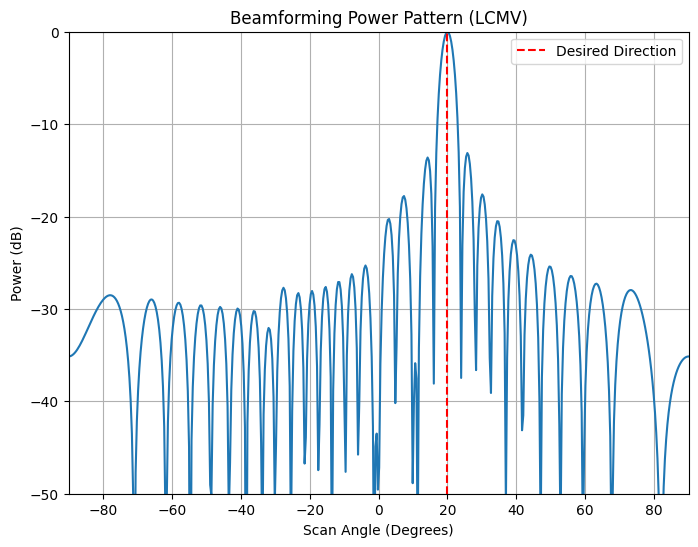

In [19]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt

# Define the number of elements and the wavelength
N = 31  # Number of elements
lambda_ = 1  # Wavelength (normalized)
d = lambda_ / 2  # Inter-element spacing (lambda/2)
k = 2 * np.pi / lambda_  # Wavenumber

# Example optimized wave vectors (x1_opt and x2_opt as row vectors)
# These would come from your convex optimization
#x1_opt = np.exp(1j * np.linspace(0, N-1, N) * np.pi / 2)  # Example steering vector
#x2_opt = np.exp(1j * np.linspace(0, N-1, N) * np.pi)  # Another example steering vector

# Define the desired direction (angle in degrees)
theta_desired = [20] # Desired direction (broadside)

# Define interference directions (angles in degrees)
theta_interference = [10, -30]  # Directions where nulls are desired
theta_interference = np.append(theta_interference,np.zeros(31-len(theta_interference)-len(theta_desired)))
# Function to compute steering vector for a given angle
def steering_vector(theta, N, d, k):
    theta_rad = np.radians(theta)  # Convert to radians
    n = np.arange(N)  # Element indices
    a = np.exp(1j * k * d * n * np.sin(theta_rad))  # Steering vector
    return a

# Compute the steering vectors for the desired and interference directions
a_d = steering_vector(theta_desired, N, d, k)  # Desired direction steering vector
a_n = [steering_vector(theta, N, d, k) for theta in theta_interference]  # Interference direction steering vectors

# Define the covariance matrix (for simplicity, assume identity matrix as a placeholder)
R = np.eye(N)  # Covariance matrix of the received signal

# Define the constraints: desired direction and interference nulls
# Desired direction: a_d^H * w = 1
# Interference directions: a_n^H * w = 0

# Constraints matrix (stacked)
A = np.vstack([a_d.conj(), np.array([an.conj() for an in a_n])])  # Stack the desired and interference constraints
b = np.array(theta_desired + [0] * len(theta_interference))  # Right-hand side of constraints

# Solve the LCMV optimization problem using a linear system
# Minimize: w^H * R * w, subject to A * w = b
print(A.shape)
print(R.shape)
print(A.T.shape)
print(b.shape)
#                       
w = linalg.lstsq(A.T @ R @ A, A.T @ R @ b)[0]  # Solve using least squares

# Normalize the weights (optional)
w = w / np.linalg.norm(w)

# Plot the power pattern (beamforming radiation pattern)
theta_scan = np.linspace(-90, 90, 500)  # Scan angles
power_pattern = np.zeros_like(theta_scan)

for i, theta in enumerate(theta_scan):
    a = steering_vector(theta, N, d, k)  # Compute steering vector for each scan angle
    power_pattern[i] = np.abs(np.dot(w.conj(), a))**2  # Calculate the power

# Normalize the power pattern and convert to dB
power_pattern_db = 10 * np.log10(power_pattern / np.max(power_pattern))

# Plot the power pattern
plt.figure(figsize=(8, 6))
plt.plot(theta_scan, power_pattern_db)
plt.title('Beamforming Power Pattern (LCMV)')
plt.xlabel('Scan Angle (Degrees)')
plt.ylabel('Power (dB)')
plt.grid(True)
plt.xlim([-90, 90])
plt.ylim([-50, 0])
plt.axvline(x=theta_desired, color='r', linestyle='--', label='Desired Direction')  # Mark desired direction
plt.legend()
plt.show()


In [48]:
import numpy as np
import scipy.optimize as opt

# Define random matrix A and B
np.random#.seed(42)  # for reproducibility
N = 31  # size of x1 and x2
m = 10**(-40 / 10)  # -40 dB in linear scale, m = 0.01
A = np.random.rand(N, N)  # random matrix A (size N x N)
B = np.random.rand(N, N)  # random matrix B (size N x N)

# Perform Singular Value Decomposition
U, S, Vh = np.linalg.svd(A)

u1 = U[0]
u2 = U[1]
# Convert S to a diagonal matrix
Sigma = np.zeros_like(A, dtype=complex)
Sigma[:len(S), :len(S)] = np.diag(S)

# Display the results
# print("Matrix A:")
# print(A)
# print("\nU (Left Singular Vectors):")
# print(U)
#print("\nSigma (Singular Values):")
#print(Sigma)
#print("\nV^H (Right Singular Vectors):")
#print(Vh)

# Define target vectors u1 and u2
#u1 = np.random.rand(N)
#u2 = np.random.rand(N)

# Define the function for the L2 norm cost
def cost_function(x):
    x1 = x[:N]
    x2 = x[N:]
    term1 = np.linalg.norm(np.dot(A, x1) - u1)
    term2 = np.linalg.norm(np.dot(A, x2) - u2)
    return term1 + term2

# Define the constraint function for B
def constraint_function(x):
    x1 = x[:N]
    x2 = x[N:]
    
    # Compute the transformations for the constraints
    B_x1_x2 = np.dot(B, x1 + x2)  # transformation for x1 + x2
    B_x1_x2_2 = np.dot(B, x1 + x2 * np.exp(1j * np.pi / 2))  # transformation for x1 + x2 * exp(j*pi/2)
    B_x1_x2_3 = np.dot(B, x1 + x2 * np.exp(1j * np.pi))  # transformation for x1 + x2 * exp(j*pi)
    B_x1_x2_4 = np.dot(B, x1 + x2 * np.exp(1j * 3 * np.pi / 2))  # transformation for x1 + x2 * exp(j*3*pi/2)
    
    # Compute the absolute values and check if they are within the constraint
    constraint1 = np.abs(B_x1_x2) - m
    constraint2 = np.abs(B_x1_x2_2) - m
    constraint3 = np.abs(B_x1_x2_3) - m
    constraint4 = np.abs(B_x1_x2_4) - m
    
    # All constraints must be satisfied (should be >= 0)
    return np.concatenate([constraint1, constraint2, constraint3, constraint4])

# Initial guess for x1 and x2 (random initialization)
x_initial = np.random.rand(2 * N)

# Define the constraint bounds (for each constraint, the value must be non-negative)
constraints = {'type': 'ineq', 'fun': lambda x: constraint_function(x)}

# Run the optimization
result = opt.minimize(cost_function, x_initial, constraints=constraints, method='SLSQP')

# Check the result
if result.success:
    optimized_x = result.x
    x1_opt = optimized_x[:N]
    x2_opt = optimized_x[N:]
    print("Optimization successful!")
    print("Optimized x1:", x1_opt)
    print("Optimized x2:", x2_opt)
else:
    print("Optimization failed:", result.message)


Optimization successful!
Optimized x1: [-0.09684147  0.18680132  0.10829156  0.23652949  0.13972973  0.1765962
  0.26191907 -0.28227479 -0.00879593 -0.14085477  0.04161451 -0.02860607
 -0.19155433  0.09633504 -0.24719581  0.00446256  0.27247352 -0.13006623
 -0.09538239  0.03894657 -0.37213696 -0.28402147 -0.10263084  0.01919818
  0.01499239  0.22053473  0.04845598 -0.33055836  0.31555197  0.27702318
  0.04956705]
Optimized x2: [-0.05912502  0.18873954  0.1299151   0.15348221 -0.00352791  0.16094886
  0.21177041 -0.12237218  0.20300071 -0.06785326  0.07868846 -0.07462347
 -0.09324732 -0.0769234  -0.14540872 -0.04357948  0.19388127 -0.287417
 -0.16306431  0.30222946 -0.24373239 -0.24759478 -0.02176071 -0.21103908
 -0.01911625  0.19677342 -0.02596691 -0.3602704   0.43214434  0.23093856
 -0.13253851]


(1, 31)


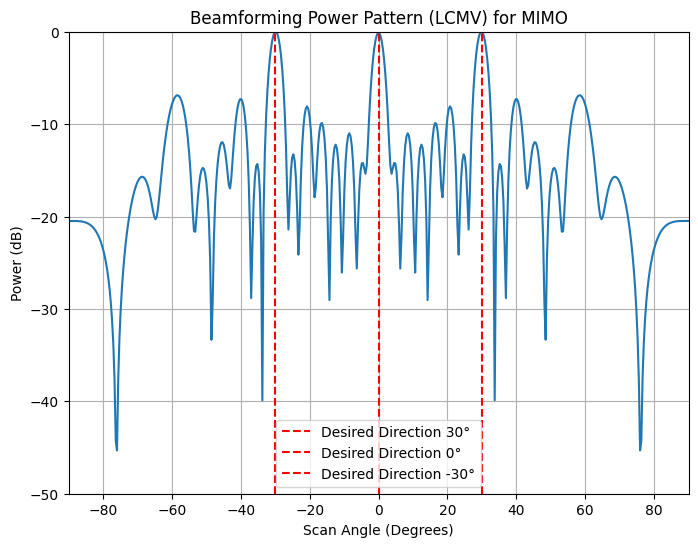

In [1]:
import numpy as np
import scipy.optimize as opt

# Define random matrix A and B
np.random#.seed(42)  # for reproducibility
N = 31  # size of x1 and x2
m = 10**(-40 / 10)  # -40 dB in linear scale, m = 0.01
num_rows = 31
num_columns = 31

# Initialize the matrix with v1 as the first column
matrix = np.zeros((num_rows, num_columns))

# Set the first column to v1
xdd = [[1,0] + [0]*29]
print(np.array(xdd).shape)
matrix[0] = np.array(xdd).reshape(1,-1)
xdd = [[ 0, 1] + [0]*29]
matrix[:,1] =  np.array(xdd).reshape(1,-1)
A = matrix
#A = #np.ones(31**2).reshape(31,31)#np.random.rand(N, N)  # random matrix A (size N x N)
B = np.random.rand(N, N)  # random matrix B (size N x N)

# Perform Singular Value Decomposition
U, S, Vh = np.linalg.svd(A)

u1 = U[0]
u2 = U[1]
# Convert S to a diagonal matrix
Sigma = np.zeros_like(A, dtype=complex)
Sigma[:len(S), :len(S)] = np.diag(S)

# Display the results
# print("Matrix A:")
# print(A)
# print("\nU (Left Singular Vectors):")
# print(U)
#print("\nSigma (Singular Values):")
#print(Sigma)
#print("\nV^H (Right Singular Vectors):")
#print(Vh)

# Define target vectors u1 and u2
#u1 = np.random.rand(N)
#u2 = np.random.rand(N)

# Define the function for the L2 norm cost
def cost_function(x):
    x1 = x[:N]
    x2 = x[N:]
    term1 = np.linalg.norm(np.dot(A, x1) - u1)
    term2 = np.linalg.norm(np.dot(A, x2) - u2)
    return term1 + term2

# Define the constraint function for B
def constraint_function(x):
    x1 = x[:N]
    x2 = x[N:]
    
    # Compute the transformations for the constraints
    B_x1_x2 = np.dot(B, x1 + x2)  # transformation for x1 + x2
    B_x1_x2_2 = np.dot(B, x1 + x2 * np.exp(1j * np.pi / 2))  # transformation for x1 + x2 * exp(j*pi/2)
    B_x1_x2_3 = np.dot(B, x1 + x2 * np.exp(1j * np.pi))  # transformation for x1 + x2 * exp(j*pi)
    B_x1_x2_4 = np.dot(B, x1 + x2 * np.exp(1j * 3 * np.pi / 2))  # transformation for x1 + x2 * exp(j*3*pi/2)
    
    # Compute the absolute values and check if they are within the constraint
    constraint1 = np.abs(B_x1_x2) - m
    constraint2 = np.abs(B_x1_x2_2) - m
    constraint3 = np.abs(B_x1_x2_3) - m
    constraint4 = np.abs(B_x1_x2_4) - m
    
    # All constraints must be satisfied (should be >= 0)
    return np.concatenate([constraint1, constraint2, constraint3, constraint4])

# Initial guess for x1 and x2 (random initialization)
x_initial = np.random.rand(2 * N)

# Define the constraint bounds (for each constraint, the value must be non-negative)
constraints = {'type': 'ineq', 'fun': lambda x: constraint_function(x)}

# Run the optimization
result = opt.minimize(cost_function, x_initial, constraints=constraints, method='SLSQP')

# Check the result
if result.success:
    optimized_x = result.x
    x1_opt = optimized_x[:N]
    x2_opt = optimized_x[N:]
    #print("Optimization successful!")
    #print("Optimized x1:", x1_opt)
    #print("Optimized x2:", x2_opt)
else:
    print("Optimization failed:", result.message)

import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt

# Define the number of elements and the wavelength
N = 31  # Number of elements
lambda_ = 1  # Wavelength (normalized)
d = lambda_ / 2  # Inter-element spacing (lambda/2)
k = 2 * np.pi / lambda_  # Wavenumber

# Define the desired directions (angles in degrees) for MIMO system
theta_desired = [30,0,-30]  # Example: Two desired directions for MIMO

# Define interference directions (angles in degrees)
theta_interference = [90]  # Directions where nulls are desired
theta_interference = np.append(theta_interference, np.ones(31 - len(theta_interference) - len(theta_desired))*90)

# Function to compute steering vector for a given angle
def steering_vector(theta, N, d, k,x_opt):
    theta_rad = np.radians(theta)  # Convert to radians
    n = np.arange(N)  # Element indices
    a = x_opt*np.exp(1j * k * d * n * np.sin(theta_rad))  # Steering vector
    return a


x_opt = 1#x1_opt

# Compute the steering vectors for the desired and interference directions
a_d = [steering_vector(theta, N, d, k,(x1_opt)) for theta in theta_desired]  # Desired direction steering vectors
a_n = [steering_vector(theta, N, d, k,0) for theta in theta_interference]  # Interference direction steering vectors

# Define the covariance matrix (for simplicity, assume identity matrix as a placeholder)
R = np.eye(N)  # Covariance matrix of the received signal

# Define the constraints: desired directions and interference nulls
# Desired direction: a_d^H * w = 1 for each desired direction
# Interference directions: a_n^H * w = 0 for each interference direction
#print(A.shape)
# Constraints matrix (stacked for MIMO and interference nulls)
A = np.vstack([np.array([ad.conj() for ad in a_d]), np.array([an.conj() for an in a_n])])  # Stack the desired and interference constraints
b = np.array([1] * len(a_d) + [0] * (len(a_n)))  # Right-hand side of constraints for MIMO and interference

# Solve the LCMV optimization problem using a linear system
# Minimize: w^H * R * w, subject to A * w = b
w = linalg.lstsq(A.T @ R @ A, A.T @ R @ b)[0]  # Solve using least squares

# Normalize the weights (optional)
w = w / np.linalg.norm(w)

# Plot the power pattern (beamforming radiation pattern)
theta_scan = np.linspace(-90, 90, 500)  # Scan angles
power_pattern = np.zeros_like(theta_scan)

for i, theta in enumerate(theta_scan):
    a = steering_vector(theta, N, d, k,(x_opt))  # Compute steering vector for each scan angle
    power_pattern[i] = np.abs(np.dot(w.conj(), a))**2  # Calculate the power

# Normalize the power pattern and convert to dB
power_pattern_db = 10 * np.log10(power_pattern / np.max(power_pattern))

# Plot the power pattern
plt.figure(figsize=(8, 6))
plt.plot(theta_scan, power_pattern_db)
plt.title('Beamforming Power Pattern (LCMV) for MIMO')
plt.xlabel('Scan Angle (Degrees)')
plt.ylabel('Power (dB)')
plt.grid(True)
plt.xlim([-90, 90])
plt.ylim([-50, 0])

# Mark the desired directions
for theta in theta_desired:
    plt.axvline(x=theta, color='r', linestyle='--', label=f'Desired Direction {theta}°')

plt.legend()
plt.show()


In [106]:
import numpy as np
import scipy.optimize as opt

# Define random matrix A and B
np.random#.seed(42)  # for reproducibility
N = 31  # size of x1 and x2
m = 10**(-40 / 10)  # -40 dB in linear scale, m = 0.01
num_rows = 31
num_columns = 31

# Initialize the matrix with v1 as the first column
matrix = np.zeros((num_rows, num_columns))

# Set the first column to v1
xdd = [[1,0] + [0]*29]
print(np.array(xdd).shape)
matrix[0] = np.array(xdd).reshape(1,-1)
xdd = [[ 0, 1] + [0]*29]
matrix[:,1] =  np.array(xdd).reshape(1,-1)
A = matrix
#A = #np.ones(31**2).reshape(31,31)#np.random.rand(N, N)  # random matrix A (size N x N)
B = np.random.rand(N, N)  # random matrix B (size N x N)

# Perform Singular Value Decomposition
U, S, Vh = np.linalg.svd(A)

u1 = U[0]
u2 = U[1]
# Convert S to a diagonal matrix
Sigma = np.zeros_like(A, dtype=complex)
Sigma[:len(S), :len(S)] = np.diag(S)

# Display the results
# print("Matrix A:")
# print(A)
# print("\nU (Left Singular Vectors):")
# print(U)
#print("\nSigma (Singular Values):")
#print(Sigma)
#print("\nV^H (Right Singular Vectors):")
#print(Vh)

# Define target vectors u1 and u2
#u1 = np.random.rand(N)
#u2 = np.random.rand(N)

# Define the function for the L2 norm cost
def cost_function(x):
    x1 = x[:N]
    x2 = x[N:]
    term1 = np.linalg.norm(np.dot(A, x1) - u1)
    term2 = np.linalg.norm(np.dot(A, x2) - u2)
    return term1 + term2

# Define the constraint function for B
def constraint_function(x):
    x1 = x[:N]
    x2 = x[N:]
    
    # Compute the transformations for the constraints
    B_x1_x2 = np.dot(B, x1 + x2)  # transformation for x1 + x2
    B_x1_x2_2 = np.dot(B, x1 + x2 * np.exp(1j * np.pi / 2))  # transformation for x1 + x2 * exp(j*pi/2)
    B_x1_x2_3 = np.dot(B, x1 + x2 * np.exp(1j * np.pi))  # transformation for x1 + x2 * exp(j*pi)
    B_x1_x2_4 = np.dot(B, x1 + x2 * np.exp(1j * 3 * np.pi / 2))  # transformation for x1 + x2 * exp(j*3*pi/2)
    
    # Compute the absolute values and check if they are within the constraint
    constraint1 = np.abs(B_x1_x2) - m
    constraint2 = np.abs(B_x1_x2_2) - m
    constraint3 = np.abs(B_x1_x2_3) - m
    constraint4 = np.abs(B_x1_x2_4) - m
    
    # All constraints must be satisfied (should be >= 0)
    return np.concatenate([constraint1, constraint2, constraint3, constraint4])

# Initial guess for x1 and x2 (random initialization)
x_initial = np.random.rand(2 * N)

# Define the constraint bounds (for each constraint, the value must be non-negative)
constraints = {'type': 'ineq', 'fun': lambda x: constraint_function(x)}

# Run the optimization
result = opt.minimize(cost_function, x_initial, constraints=constraints, method='SLSQP')

# Check the result
if result.success:
    optimized_x = result.x
    x1_opt = optimized_x[:N]
    x2_opt = optimized_x[N:]
    #print("Optimization successful!")
    #print("Optimized x1:", x1_opt)
    #print("Optimized x2:", x2_opt)
else:
    print("Optimization failed:", result.message)

import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt

# Define the number of elements and the wavelength
N = 31  # Number of elements
lambda_ = 1  # Wavelength (normalized)
d = lambda_ / 2  # Inter-element spacing (lambda/2)
k = 2 * np.pi / lambda_  # Wavenumber
alpha = 45

# Define the desired directions (angles in degrees) for MIMO system
theta_desired = [30,-30]  # Example: Two desired directions for MIMO

# Define interference directions (angles in degrees)
theta_interference = [90]  # Directions where nulls are desired
theta_interference = np.append(theta_interference, np.ones(31 - len(theta_interference) - len(theta_desired))*90)

# Function to compute steering vector for a given angle
def steering_vector(theta, N, d, k,x_opt):
    theta_rad = np.radians(theta)  # Convert to radians
    n = np.arange(N)  # Element indices
    a = x_opt*np.exp(1j * k * d * n * np.sin(theta_rad))  # Steering vector
    return a


x_opt = 1#x1_opt

# Compute the steering vectors for the desired and interference directions
a_d = [steering_vector(theta, N, d, k,(x1_opt)) for theta in theta_desired]  # Desired direction steering vectors
a_n = [steering_vector(theta, N, d, k,0) for theta in theta_interference]  # Interference direction steering vectors

# Define the covariance matrix (for simplicity, assume identity matrix as a placeholder)
R = np.eye(N)  # Covariance matrix of the received signal

# Define the constraints: desired directions and interference nulls
# Desired direction: a_d^H * w = 1 for each desired direction
# Interference directions: a_n^H * w = 0 for each interference direction
#print(A.shape)
# Constraints matrix (stacked for MIMO and interference nulls)
A = np.vstack([np.array([ad.conj() for ad in a_d]), np.array([an.conj() for an in a_n])])  # Stack the desired and interference constraints
b = np.array([1] * len(a_d) + [0] * (len(a_n)))  # Right-hand side of constraints for MIMO and interference


def sidelobe_penalty(theta_scan, w, threshold_dB=-40, alpha=45):
    power_pattern = np.zeros_like(theta_scan)
    for i, theta in enumerate(theta_scan):
        a = steering_vector(theta, N, d, k,x_opt)  # Compute steering vector for each scan angle
        power_pattern[i] = np.abs(np.dot(w.conj(), a))**2  # Calculate the power

    # Normalize the power pattern
    power_pattern_db = 10 * np.log10(power_pattern / np.max(power_pattern))

    # Apply the sidelobe constraint: Power outside [-alpha, alpha] must be below threshold_dB
    outside_range = np.abs(theta_scan) > alpha
    sidelobe_violations = power_pattern_db[outside_range] > threshold_dB
    return np.sum(sidelobe_violations)  # Return number of violations (want to minimize this)


# Solve the LCMV optimization problem using a linear system
# Minimize: w^H * R * w, subject to A * w = b
w = linalg.lstsq(A.T @ R @ A, A.T @ R @ b)[0]  # Solve using least squares

# Normalize the weights (optional)
w = w / np.linalg.norm(w)

# Plot the power pattern (beamforming radiation pattern)
theta_scan = np.linspace(-90, 90, 500)  # Scan angles
power_pattern = np.zeros_like(theta_scan)

# Define a cost function that combines LCMV and the sidelobe penalty
def cost_function(w, A, R, b, theta_scan, alpha=45, threshold_dB=-40):
    # LCMV cost: w^H * R * w subject to A * w = b
    cost_lcmv = np.real(np.dot(w.conj().T, np.dot(R, w)))  # LCMV cost (beamforming)
    
    # Sidelobe penalty: Added to the cost
    penalty = sidelobe_penalty(w, theta_scan, alpha, threshold_dB)
    
    # Total cost: LCMV cost + penalty for sidelobe violations
    total_cost = cost_lcmv + penalty
    return total_cost

# Solve the optimization problem with constraints and sidelobe penalty
theta_scan = np.linspace(-90, 90, 500)  # Scan angles

# Initial guess for the weights (can be random or zeros)
w_initial = np.zeros(N)

# Minimize the cost function
from scipy.optimize import minimize
threshold_dB = -40

result = minimize(cost_function, w_initial, args=(A, R, b, theta_scan, alpha, threshold_dB), method='L-BFGS-B')

# Get the optimized weights
w_opt = result.x

# Normalize the weights (optional)
w_opt = w_opt / np.linalg.norm(w_opt)

# Plot the power pattern (beamforming radiation pattern)
power_pattern = np.zeros_like(theta_scan)
for i, theta in enumerate(theta_scan):
    a = steering_vector(theta, N, d, k)  # Compute steering vector for each scan angle
    power_pattern[i] = np.abs(np.dot(w_opt.conj(), a))**2  # Calculate the power

# Normalize the power pattern and convert to dB
power_pattern_db = 10 * np.log10(power_pattern / np.max(power_pattern))


# Plot the power pattern
plt.figure(figsize=(8, 6))
plt.plot(theta_scan, power_pattern_db)
plt.title('Beamforming Power Pattern (LCMV) for MIMO')
plt.xlabel('Scan Angle (Degrees)')
plt.ylabel('Power (dB)')
plt.grid(True)
plt.xlim([-90, 90])
plt.ylim([-50, 0])

# Mark the desired directions
for theta in theta_desired:
    plt.axvline(x=theta, color='r', linestyle='--', label=f'Desired Direction {theta}°')

plt.legend()
plt.show()


(1, 31)


ValueError: shapes (500,) and (31,) not aligned: 500 (dim 0) != 31 (dim 0)